In [28]:
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
ts = pd.read_excel('Gas_CPD.xlsx', sheet_name='Sheet1', parse_dates=['Date'], index_col='Date')
ts

,Price
Date,
2019-01-02,3.25
2019-01-03,2.72
2019-01-04,2.80
2019-01-07,2.74
2019-01-08,2.89
...,...
2025-12-23,3.38
2025-12-24,3.31
2025-12-29,4.35


Text(0, 0.5, 'Price dollars per million BTU')

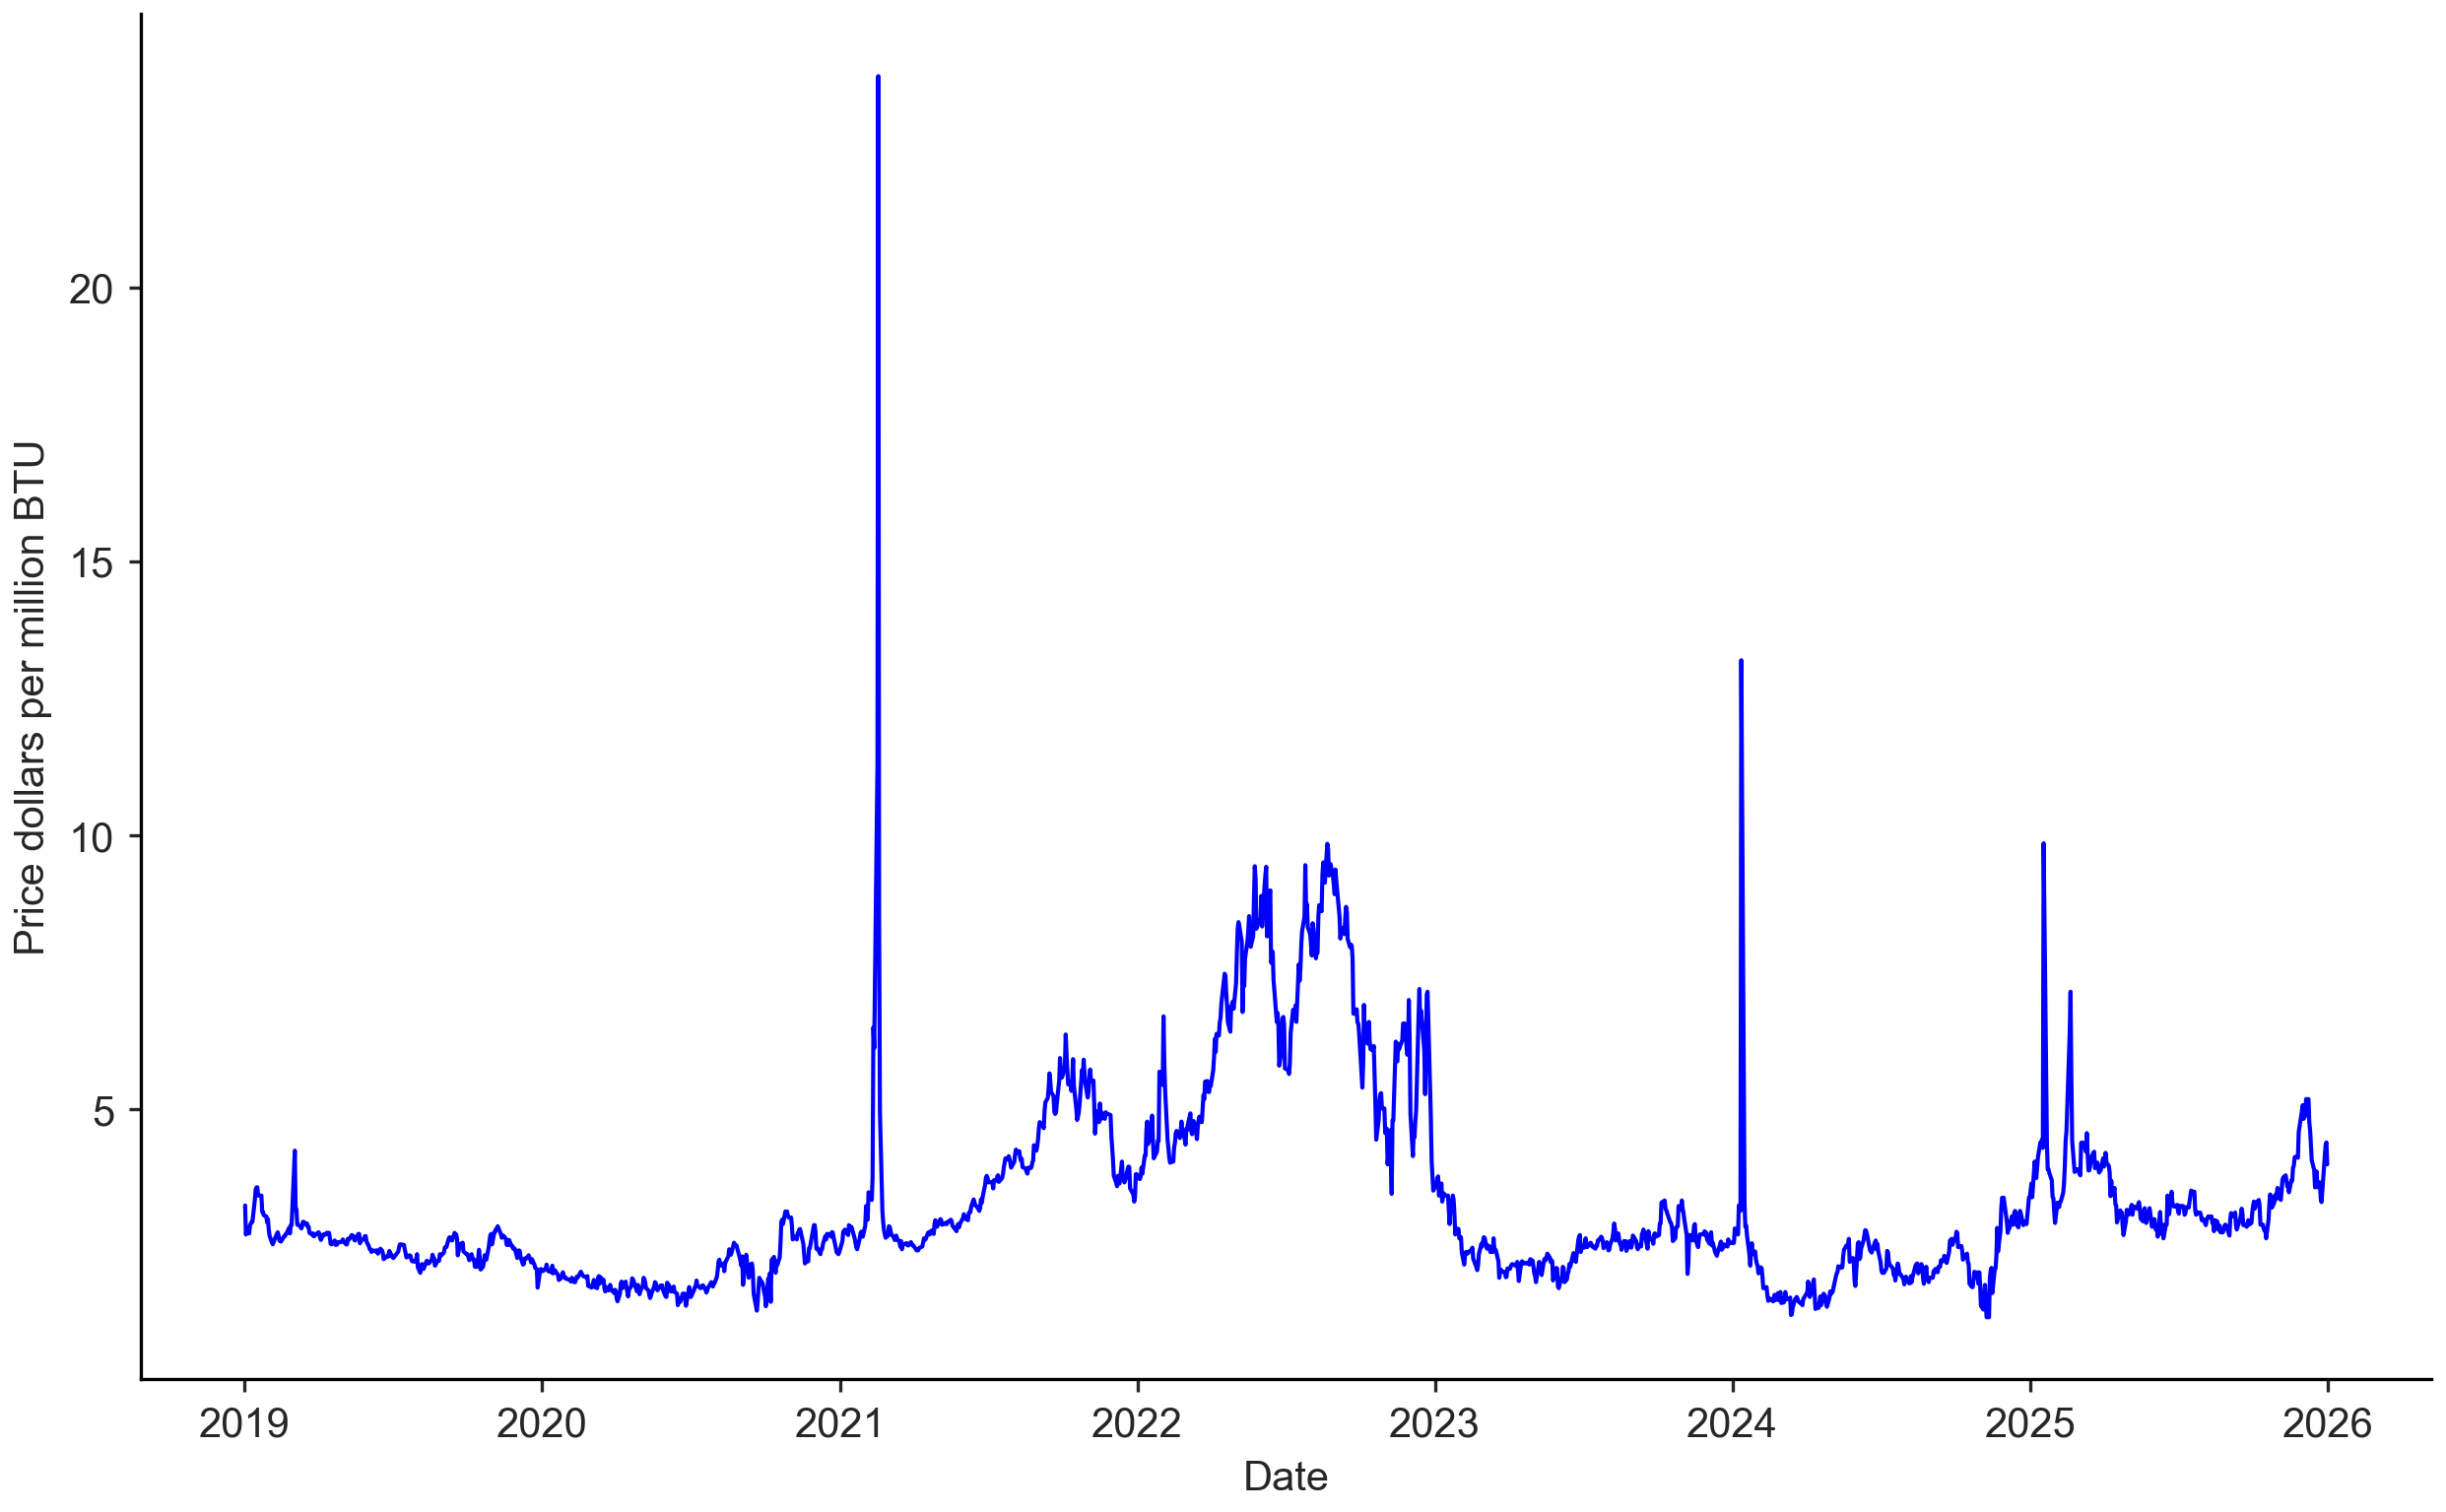

In [30]:
from plot_style import set_publication_style
set_publication_style()
#plot time series
plt.figure(figsize=(10,6))
plt.plot(ts.index, ts['Price'], label='Gas CPD', color='blue')
plt.xlabel('Date')
plt.ylabel('Price dollars per million BTU')

In [31]:
from RobustCPD import RobustCPD
from statsmodels.tsa.seasonal import seasonal_decompose

detector = RobustCPD(trimming=0.01, alpha=0.01)

# 3. fit the model
results = detector.fit(ts['Price'].values,poly_order=2)
detector.summary()

Scanning 1226 candidate dates (Polynomial Order: 2)...
ROBUST STRUCTURAL BREAK DETECTED
Estimated Break Date     : 855
Slope Change (Beta2)     : -0.0370
T-Statistic              : -97.6448
----------------------------------------
>> CONCLUSION: SIGNIFICANT BREAK DETECTED


In [32]:
ts.iloc[results['break_index']]

Price    8.46
Name: 2022-05-31 00:00:00, dtype: float64

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Initialize with NaN (so buffer zones don't plot as zero)
ts['t_stats'] = np.nan 

# 2. Extract results
indices = results['sequence_taus']
t_values = np.abs(results['sequence_beta2_tstats']) # Ensure absolute values

# 3. Fill the specific positions
# We use a temporary numpy array to handle the assignment by integer index
temp_stats = np.full(len(ts), np.nan)
temp_stats[indices] = t_values
ts['t_stats'] = temp_stats

# 4. Identify the Break Date for plotting
break_date = ts.index[results['break_index']]
break_tstat = results['beta2_t_stat']




C:\Users\Antonio\AppData\Local\Temp\ipykernel_22272\1545076373.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


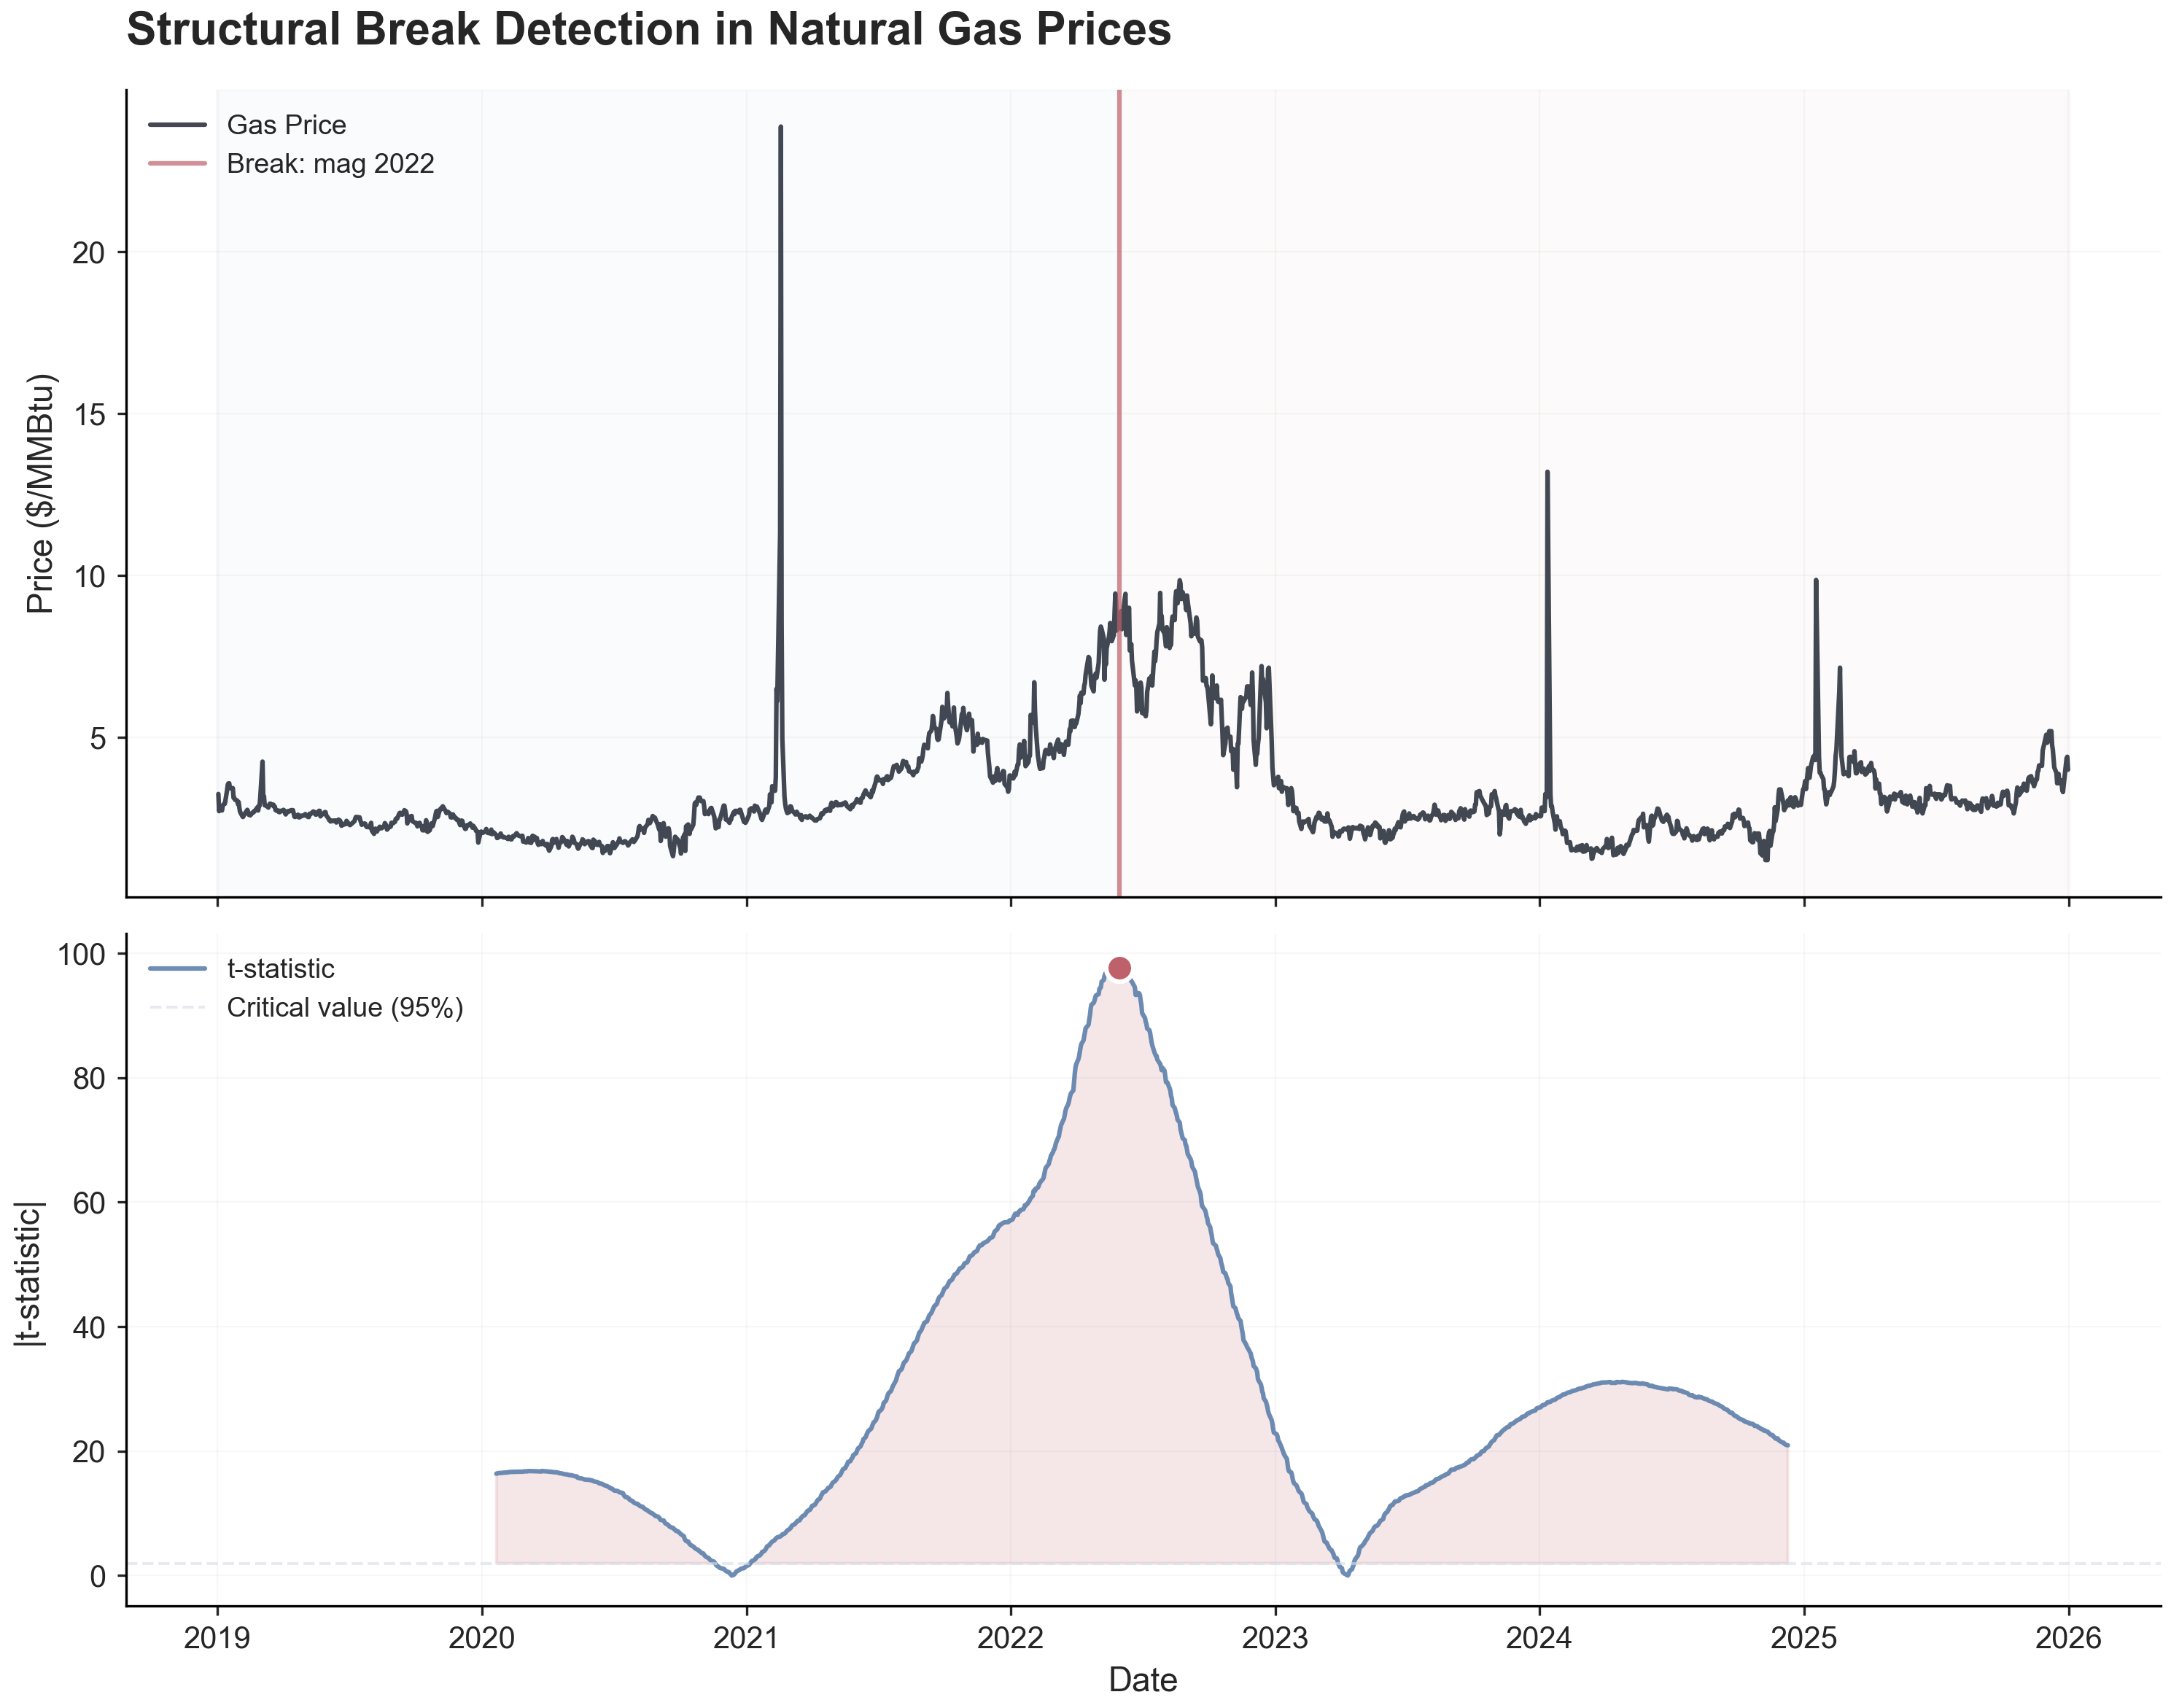

In [34]:
# Create two subplots sharing the X-axis (Dates)
from plot_style import set_publication_style
set_publication_style()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), sharex=True, 
                                gridspec_kw={'height_ratios': [1.2, 1], 'hspace': 0.05})

# Modern color palette
color_primary = '#2E3440'
color_accent = '#BF616A'
color_secondary = '#5E81AC'
color_neutral = '#D8DEE9'

# ================= TOP PANEL: PRICE SERIES =================
ax1.plot(ts.index, ts['Price'], color=color_primary, linewidth=1.5, 
         label='Gas Price', alpha=0.9)

# Add Vertical Line at the Detected Break Date
ax1.axvline(x=break_date, color=color_accent, linestyle='-', 
            linewidth=1.5, alpha=0.7, label=f'Break: {break_date.strftime("%b %Y")}')

# Subtle shaded regions before/after break
ax1.axvspan(ts.index[0], break_date, alpha=0.03, color=color_secondary)
ax1.axvspan(break_date, ts.index[-1], alpha=0.03, color=color_accent)

# Cleaner title and labels
ax1.set_title('Structural Break Detection in Natural Gas Prices', 
              fontsize=15, fontweight='600', pad=15, loc='left')
ax1.set_ylabel('Price ($/MMBtu)', fontsize=11, fontweight='500')
ax1.legend(loc='upper left', frameon=False, fontsize=9)
ax1.grid(True, linestyle='-', alpha=0.15, linewidth=0.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# ================= BOTTOM PANEL: T-STATISTICS =================
ax2.plot(ts.index, ts['t_stats'], color=color_secondary, linewidth=1.5, 
         label='t-statistic', alpha=0.9)

# Critical value line
ax2.axhline(y=1.96, color=color_neutral, linestyle='--', 
            alpha=0.6, linewidth=1, label='Critical value (95%)')

# Subtle fill under significant zone
ax2.fill_between(ts.index, 1.96, ts['t_stats'], 
                 where=(ts['t_stats'] >= 1.96), 
                 color=color_accent, alpha=0.15, interpolate=True)

# Highlight the peak
ax2.scatter([break_date], [abs(break_tstat)], color=color_accent, 
            s=80, zorder=5, edgecolors='white', linewidths=1.5)

ax2.set_ylabel('|t-statistic|', fontsize=11, fontweight='500')
ax2.set_xlabel('Date', fontsize=11, fontweight='500')
ax2.legend(loc='upper left', frameon=False, fontsize=9)
ax2.grid(True, linestyle='-', alpha=0.15, linewidth=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# ================= FORMATTING =================
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()